# Homework1 for Trustworthy Machine Learning

作业要求请参考PPT

如有任何问题，欢迎发邮件至助教邮箱或在微信群里提问：210013020@stu.pku.edu.cn

## Deadline
**中文/English: 3/22 release, 4/6 24:00 due**

In [ ]:
# Install other package if neccesary.
%pip install lime==0.1.1.37

In [1]:
# Import package
import torch
import json
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from torch.autograd import Variable
from typing import Callable, List, Tuple

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'mps'
device

'cuda'

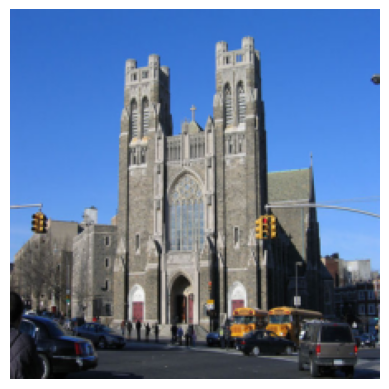

In [3]:
# Test whether the jupyter works well.
np.random.seed(10)
img = Image.open('./test.JPEG')
img = img.convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
img = transform(img)
img_hwc = img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
img = img.unsqueeze(dim=0)

In [4]:
# Load the model
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
net = resnet50(num_classes=1000, pretrained=True)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), net)
model.eval()

/home/rj/.conda/envs/fai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rj/.conda/envs/fai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

The label of image 0 is : tench
The label of image 1 is : English_springer
The label of image 2 is : tape_player
The label of image 3 is : chain_saw
The label of image 4 is : church
The label of image 5 is : French_horn
The label of image 6 is : garbage_truck
The label of image 7 is : gas_pump
The label of image 8 is : golf_ball
The label of image 9 is : parachute


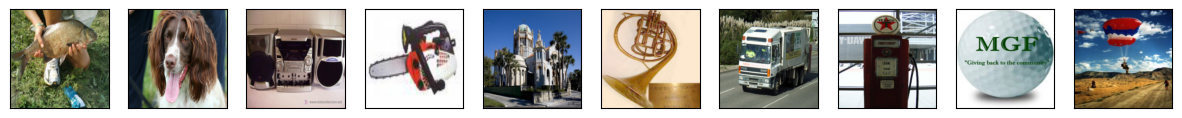

In [5]:
# Load the dataset
dataset = ImageFolder(root="./ImageNet_subset/", transform=transform)
dataset_loader = DataLoader(dataset, batch_size=10, num_workers=6)
for image, _ in dataset_loader:
    result = model(image)
    real_label = torch.argmax(result,dim = -1).numpy()


# Print the label
for j, label in enumerate(real_label):
    class_name = json.load(open("imagenet_class_index.json"))[str(label.item())]
    print("The label of image {:d} is :".format(j), class_name[1])


# Show the image
img_indices = [i for i in range(10)]
all_image,_ = next(iter(dataset_loader))
all_image = all_image.mul(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu', torch.uint8).numpy()
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(all_image):
  axs[i].imshow(img)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

# Lime
[Lime](https://github.com/marcotcr/lime) is a package about explaining what machine learning classifiers are doing. We can first use it to observe the model.

In [ ]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)
    # output: the output of the model.
    input = np.transpose(input, (0, 3, 1, 2))  # (batches, channels, height, width)
    input_tensor = torch.from_numpy(input).float()
    # model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    return output.detach().cpu().numpy()
    ###################################
    # write the code here
    # return output.detach().numpy()
    ###################################

def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage
    # doc: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#slic
    return slic(input, n_segments=200, compactness=1, sigma=1, start_label=1)

img_indices = [i for i in range(10)]
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))


# fix the random seed to make it reproducible
explainer = lime_image.LimeImageExplainer()
#<-----!>
for idx, (image,label) in enumerate(zip(all_image,real_label)):
    x = (image/255).astype(np.double)
    
    explaination = explainer.explain_instance(
        image=x,
        classifier_fn=predict,
        labels=(10,),
        hide_color=0,
        top_labels=1,
        num_features=11,
        num_samples=1000,
        batch_size=10,
        segmentation_fn=segmentation,
        distance_metric='cosine',
        model_regressor=None,
        random_seed=10,
        # progress_bar=True
    )
    # Refer the doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance
    ###################################
    # write the code here
    ###################################


    # Turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    lime_img, mask = explaination.get_image_and_mask(label=label.item(),positive_only=False,hide_rest=False,num_features=11,min_weight=0.05)
    axs[idx].imshow(lime_img)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
plt.close()

In [6]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())


## Saliency Map
What is Saliency map?

The heatmaps that highlight pixels of the input image that contribute the most in the classification task.

Ref: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

We put an image into the model, forward then calculate the loss referring to the label. Therefore, the loss is related to:

*   image
*   model parameters
*   label

Generally speaking, we change model parameters to fit "image" and "label". When backward, we calculate the partial differential value of **loss to model parameters**.

Now, we have another look. When we change the image's pixel value, the partial differential value of **loss to image** shows the change in the loss. We can say that it means the importance of the pixel. We can visualize it to demonstrate which part of the image contribute the most to the model's judgment.

/tmp/ipykernel_10075/692247529.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9


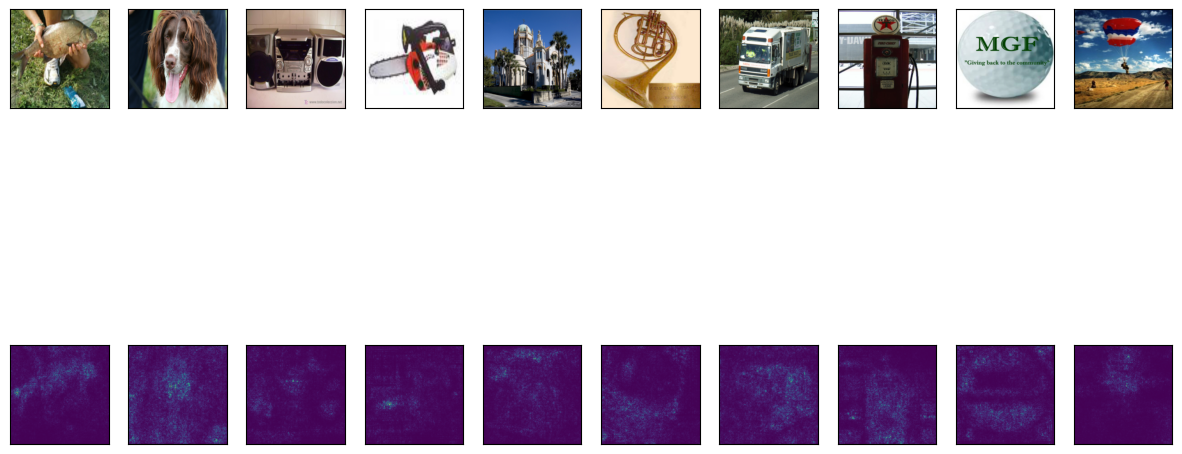

In [7]:
# Tips.
# What is permute?
# In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
# In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
# permute is a tool for permuting dimensions of tensors
# For example, img.permute(1, 2, 0) means that,
# - 0 dimension is the 1 dimension of the original tensor, which is height
# - 1 dimension is the 2 dimension of the original tensor, which is width
# - 2 dimension is the 0 dimension of the original tensor, which is channels



def compute_saliency_maps(x, y, model):
  # input: the input image, the ground truth label, the model
  # output: the saliency maps of the images
  # We need to normalize each image, because their gradients might vary in scale, use the "normalize" function.

  '''
    x: (tensor) [10, 3, 224, 224]), float32
  '''
  # print(x.shape)
  model.eval()
  device = next(model.parameters()).device
  x = normalize(x.to(device))
  x.requires_grad_()
  y = y.to(device)
  
  # 在循环前启用cudnn基准优化
  torch.backends.cudnn.benchmark = True

  # 使用混合精度计算
  with torch.cuda.amp.autocast():
    outputs = model(x)
  scores = outputs[torch.arange(outputs.size(0)), y]
  grads = []
  for i in range(x.size(0)):
    print(f'image {i}')
    grad = torch.autograd.grad(
      outputs=scores[i],
      inputs=x,
      retain_graph=True,
      allow_unused=True,
      create_graph=False
    )[0][i]
    grads.append(normalize(grad.abs().max(dim=0)[0]))
  
  del outputs, scores
  torch.cuda.empty_cache()
  saliency_maps = torch.stack(grads)
  return saliency_maps.detach()
  ###################################
  # write the code here
  # return saliencies
  ###################################

image,_ = next(iter(dataset_loader))
result = model(image)
label = torch.argmax(result,dim = -1)



saliencies = compute_saliency_maps(image, label, model)
# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))

for row, target in enumerate([image, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).detach().mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy())
      axs[row][column].set_xticks([])
      axs[row][column].set_yticks([])
    else:
      axs[row][column].imshow(img.numpy())
      axs[row][column].set_xticks([])
      axs[row][column].set_yticks([])

plt.show()
plt.close()

In [7]:
# 输入张量形状为 [C, H, W]
def normalize_saliency(saliency):
    # (H,W) → (H*W)
    c, h, w = saliency.shape
    flattened = saliency.view(c, -1)  # [C, H*W]
    
    max_vals, _ = flattened.max(dim=1, keepdim=True)  # [C, 1]
    min_vals, _ = flattened.min(dim=1, keepdim=True)  # [C, 1]
    
    # [C, 1] → [C, 1, 1]
    max_vals = max_vals.view(c, 1, 1)
    min_vals = min_vals.view(c, 1, 1)
    
    normalized = (saliency - min_vals) / (max_vals - min_vals + 1e-10)
    return torch.clamp(normalized, 0.0, 1.0)

## Smooth Grad
The method of Smooth grad is to randomly add noise to the image and get different heatmaps. The average of the heatmaps would be more robust to noisy gradient.

ref: https://arxiv.org/pdf/1706.03825.pdf

working in torch.Size([3, 224, 224])
    woring in epoch 0 
    woring in epoch 1 
    woring in epoch 2 
    woring in epoch 3 
    woring in epoch 4 
    woring in epoch 5 
    woring in epoch 6 
    woring in epoch 7 
    woring in epoch 8 
    woring in epoch 9 
    torch.Size([3, 224, 224])
working in torch.Size([3, 224, 224])
    woring in epoch 0 
    woring in epoch 1 
    woring in epoch 2 
    woring in epoch 3 
    woring in epoch 4 
    woring in epoch 5 
    woring in epoch 6 
    woring in epoch 7 
    woring in epoch 8 
    woring in epoch 9 
    torch.Size([3, 224, 224])
working in torch.Size([3, 224, 224])
    woring in epoch 0 
    woring in epoch 1 
    woring in epoch 2 
    woring in epoch 3 
    woring in epoch 4 
    woring in epoch 5 
    woring in epoch 6 
    woring in epoch 7 
    woring in epoch 8 
    woring in epoch 9 
    torch.Size([3, 224, 224])
working in torch.Size([3, 224, 224])
    woring in epoch 0 
    woring in epoch 1 
    woring in epoch 2 
   

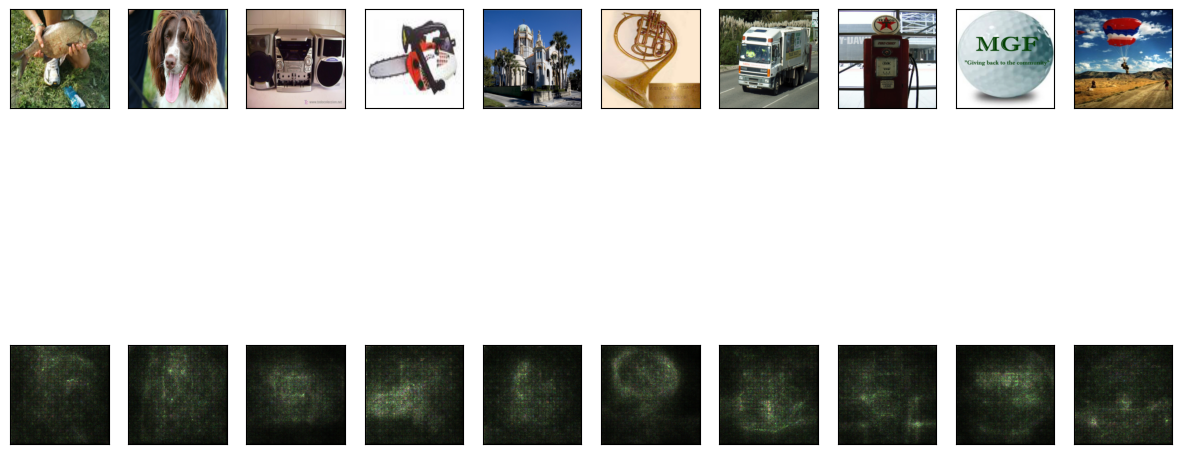

In [8]:
dataset = ImageFolder(root="./ImageNet_subset/", transform=transform)
dataset_loader = DataLoader(dataset, batch_size=10, num_workers=6)
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), resnet50(num_classes=1000, pretrained=True))
model.eval()
def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
  # input: the input image, the ground truth label, the model, the number for average, Sigma multiplier when calculating std of noise
  # output: the saliency maps of the images
  # epoch = 2
  print(f'working in {x.shape}')
  model.eval()


  device = next(model.parameters()).device
  x = x.to(device)
  y = y.to(device)
  total_grad = torch.zeros_like(x, device=device)
  diff = x.max() - x.min()
  sigma = param_sigma_multiplier * diff

  for i in range(epoch):
    print(f'    woring in epoch {i} ')

    x_noise = (x + torch.randn_like(x) * sigma).detach()
    x_noise.requires_grad_()

    output = model(x_noise.unsqueeze(0))
    score = output[0, y]

    grad = torch.autograd.grad(score, x_noise, retain_graph=False)[0]
    total_grad += grad.abs()
  
  normalized_grad = total_grad / epoch
  # 分通道归一化 (关键修改2)
 
    
  normalized_grad = normalize(normalized_grad)
  print(f'    {normalized_grad.shape}')
  return normalized_grad.detach().cpu()
     


smooth = []
image,_ = next(iter(dataset_loader))
result = model(image)
label = torch.argmax(result,dim = -1)
for i, l in zip(image, label):
  smooth.append(smooth_grad(i, l, model, 10, 0.4))
smooth = np.stack(smooth)
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([image, smooth]):
  for column, img in enumerate(target):
    if row==0:
        axs[row][column].imshow(img.permute(1, 2, 0).detach().mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy())
        axs[row][column].set_xticks([])
        axs[row][column].set_yticks([])
    else:
        axs[row][column].imshow(np.transpose(img.reshape(3,224,224), (1,2,0)))
        axs[row][column].set_xticks([])
        axs[row][column].set_yticks([])

## Grad-cam
The method of Grad-cam is used to get the heatmaps of the models through the calculated gradients on the intermediate features.

ref: https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf

before backward
after backward
compute_cam_per_layer  Loop over layer 0
before multi_payer shape: (10, 1, 224, 224)
after aggregate_multi_layers:  (10, 224, 224)
grayscale_cam layer (10, 224, 224)


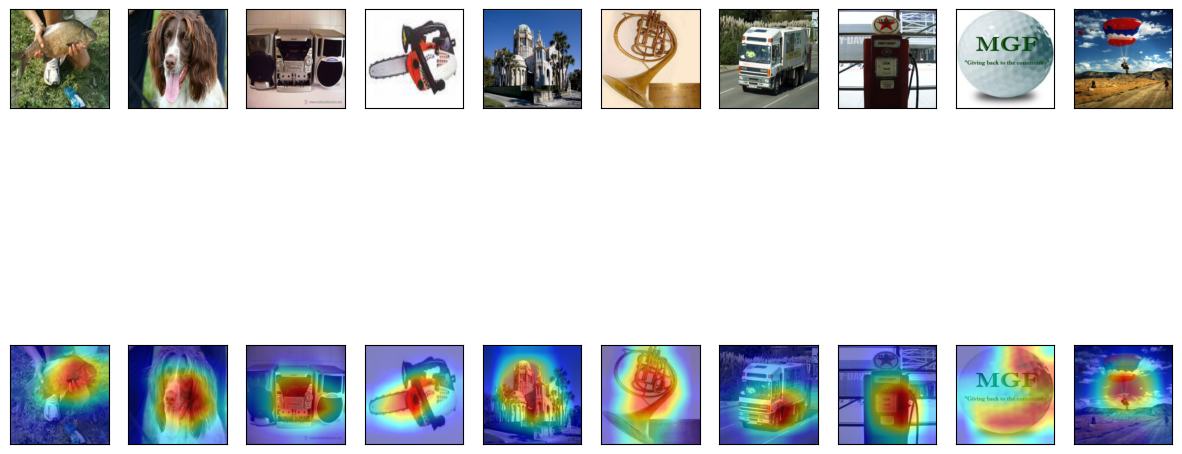

In [16]:
def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)
    return result

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.gradients = []
        self.activations = []
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return
        # Gradients are computed in reverse order
        def _store_grad(grad):
            self.gradients = [grad.cpu().detach()] + self.gradients
        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()




def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


class GradCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module]) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.model = model
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        grads: torch.Tensor) -> np.ndarray:
        return np.mean(grads, axis=(2, 3))

    def get_cam_image(self,
                      activations: torch.Tensor,
                      grads: torch.Tensor) -> np.ndarray:
        # input: the activation, the gradient(4D tensor)
        # output: cam of a specific layer
        # 计算通道权重（全局平均池化的梯度）
        # weights = self.get_cam_weights(grads) # N, C
        weights = np.mean(grads, axis=(2, 3), keepdims=True)  # 形状: [B, C, 1, 1]
        # 加权激活图（维度对齐处理）
        weighted_activations = weights * activations # N, C, H, W
    
        # 通道维度求和并应用ReLU
        cam = weighted_activations.sum(axis=1) # N, H, W
        # cam = np.maximum(cam, 0)  # ReLU操作
    
        # 归一化处理
         # 逐样本归一化
        cam_min = cam.min(axis=(1, 2), keepdims=True)
        cam_max = cam.max(axis=(1, 2), keepdims=True)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        return cam
        ###################################
        # write the code here
        # return cam
        ###################################

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module]) -> np.ndarray:
        outputs = self.activations_and_grads(input_tensor)
        self.model.zero_grad()
        loss = sum([target(output)
                   for target, output in zip(targets, outputs)])
        print('before backward')
        loss.backward(retain_graph=True)
        print('after backward')
        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor)
        return self.aggregate_multi_layers(cam_per_layer)


    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size =  (input_tensor.size(-1), input_tensor.size(-2))
        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]
            ###################################
            # write the code here
            ###################################
            # start of RJ
            print(f'compute_cam_per_layer  Loop over layer {i}')

            cam = self.get_cam_image(layer_activations, layer_grads)
        
            # 调整尺寸（使用scale_cam_image统一处理）
            scaled_cam = scale_cam_image(cam, target_size=target_size)
            scaled_cam = np.expand_dims(scaled_cam, axis=1) # Image_num, H, W
            print(f'before multi_payer shape: {scaled_cam.shape}')
            cam_per_target_layer.append(scaled_cam)
            # End of RJ
        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:

        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        print(f'after aggregate_multi_layers:  {result.shape}')
        return scale_cam_image(result)


    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None) -> np.ndarray:
        return self.forward(input_tensor,
                            targets)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True




model = resnet50(pretrained=True)
label = torch.argmax(result,dim = -1).numpy()
target_layers = [model.layer4[-1]]
image,_ = next(iter(dataset_loader))
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(i) for i in label]
grayscale_cam = cam(input_tensor=image, targets=targets)
print(f'grayscale_cam layer {grayscale_cam.shape}')
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for column, single_image in enumerate(image):
    axs[0][column].imshow(single_image.permute(1, 2, 0).detach().mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy())
    axs[0][column].set_xticks([])
    axs[0][column].set_yticks([])
    axs[1][column].imshow(show_cam_on_image(single_image.permute(1, 2, 0).detach().to('cpu').numpy(),grayscale_cam[column],use_rgb=True))
    axs[1][column].set_xticks([])
    axs[1][column].set_yticks([])